# Researcher Evaluation - H-index

第三章で研究評価についての事例を見たが、本章では研究者評価を行う。研究者評価の指標の一つとして、h-indexを取り上げる。

本章の目的：
* pyalexの関数について理解する
* APIを使って、その他のデータベースと組み合わせてデータを分析する
* 研究者を評価する指標について考察する

# 説明

## h-index（h指数）とは何か？

h-indexはアメリカの物理学者Jorge E. Hirsch氏が2005年に発表した研究者の評価指標です。

> Abstract: I propose the index h, defined as the number of papers with citation number ≥h, as a useful index to characterize the scientific output of a researcher. 
> (要旨：私は、研究者の科学的産出を特徴づける有用な指標として、被引用数がhより大きい論文の数と定義される指数hを提案した。)
> 
> Hirsch, J. E. (2005). An index to quantify an individual's scientific research output. Proceedings of the National Academy of Sciences, 102(46), 16569-16572. https://www.pnas.org/doi/abs/10.1073/pnas.0507655102

ある科学者が発表したN本論文の中で、**h回以上引用された論文がh本あり**、それ以外のN-h本論文の被引用数が全部hより小さい場合、その科学者の**h-indexはh**です。
 
例えば、h-index=**20**というのは、被引用数が**20**以上の論文が**20**本あり、それ以外の論文はすべて被引用数が20本未満だということです。

## なぜ提案したのか？どうして重要なのか？

リソースが限られた世界で、個人の科学的成果の累積的影響力を定量化することは、評価や比較のために必要とされます。

|指数|長所|短所|
|:-|:-|:-|
|発表論文数(N)|研究者の生産力を測る|論文の影響力が無視される|
|総被引用数(C)|研究者の総影響力を測る|1. 少数の大ヒット論文に歪まれる可能性があり、特に、これらの大ヒットが共著である場合、個人のキャリア全体を代表していない可能性がある。<br>2. 引用度の高いレビューに過度な重みを与えている。|
|平均被引用数(C/N)|異なる年齢の科学者を比較することができる|1. 生産性が高い研究者に不利になる。2. 高被引用数の論文に歪まれる可能性がある。|
|被引用数≥cの論文数|上記の指標の欠点を克服し、広範囲かつ持続的な影響を測る。|cは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|
|上位q個の論文の被引用数|上記の指標の欠点をほとんど克服する。|1. 単一の数値ではないため、科学者を比較するには困難である。<br>2. qは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|


## 0. 準備：pyalex

In [22]:
import sys
import os

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path


[Errno 2] No such file or directory: '/content/sample_data/'
/Users/ti/Documents/code/scisciJP2024_tutorial
Cloning into 'scisciJP2024_tutorial'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (82/82), done.
^Cceiving objects:  11% (54/489), 19.72 MiB | 651.00 KiB/s 
fetch-pack: unexpected disconnect while reading sideband packet
/Users/ti/Documents/code/scisciJP2024_tutorial


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/scisciJP2024_tutorial'

In [23]:
%pip install pyalex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyalex
from pyalex import Works, Authors, Institutions
from pprint import pprint
import util
import tqdm

pyalex.config.email = "your@email.address"

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## １. h-indexの計算方法：Stephen Hawkingを例に

理論物理学者Stephen Hawkingを例に、h-indexの計算方法を示します。このセクションでは、お家に帰ったあともpyalexを触ってみられるように、pyalexの基本的な使い方について少し細かく説明します。要点を抑えれば非常にシンプルですので、ぜひ試してみてください。

- citations_test: 論文の発表日順に並べた被引用数のリスト。
- sorted_citations_test: 被引用数が大きい順に並べた被引用数のリスト。

In [34]:
# まずは、pyalexのsearchを使用してStephen Hawkingのデータを検索します
name = "Stephen Hawking"

# searchは、タイトル、アブストラクト、著者名やキーワードなどから横断的に検索して、当てはまる結果を返してくれます。
# searchの検索対象は、対象とするデータによって異なります。　https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/search-entities#the-search-parameter
authors_df = pd.DataFrame(Authors().search(name).get())

# 取得したauthor_dfを表示します
authors_df.sort_values(by="relevance_score", ascending=False)

# 同姓同名が多数ヒットすることがあります。所属機関や、relevance_scoreなどから判断しなければいけません。自動でやる場合には工夫が必要です。
# 今回対象としているS. W. Hawkingは幸いにしてそんなに同姓同名が少ないです。有名な人なので、わかりやすくてよかったです。

# # 検索結果から著者を指定します
# i = 0
# author_id = authors_df.loc[i,"id"]
# author_name = authors_df.loc[i,"display_name"]

# # 著者データを確認します
# data = Authors()[author_id]
# # 著者の最新の所属機関
# institutions = [entry['display_name'] for entry in data['last_known_institutions']]
# print('Last known institutions of the select author:')
# pprint(institutions)
# # 著者が発表した論文のテーマ
# concepts = [entry['display_name'] for entry in data['x_concepts']]
# print('\nConcepts of the select author:')
# pprint(concepts)

,id,orcid,display_name,display_name_alternatives,relevance_score,works_count,cited_by_count,summary_stats,ids,affiliations,last_known_institution,last_known_institutions,x_concepts,counts_by_year,works_api_url,updated_date,created_date
0,https://openalex.org/A5066175077,None,S. W. Hawking,"[Stephen Hawking, S. W Hawking, Stephen W. Haw...",33953.220000,415,72096,"{'2yr_mean_citedness': 0.0, 'h_index': 92, 'i1...",{'openalex': 'https://openalex.org/A5066175077'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I241749', 'ror': ...","[{'id': 'https://openalex.org/I241749', 'ror':...","[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2024, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-03-12T03:05:06.731185,2023-07-21
1,https://openalex.org/A5016634951,None,Stephen Hawking,"[Stephen Hawking Lucy Hawking, S. Hawking, Ste...",2805.859100,53,221,"{'2yr_mean_citedness': 0.0, 'h_index': 8, 'i10...",{'openalex': 'https://openalex.org/A5016634951'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I1325620243', 'ro...","[{'id': 'https://openalex.org/I1325620243', 'r...","[{'id': 'https://openalex.org/C121332964', 'wi...","[{'year': 2023, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-03-01T01:35:49.680102,2023-07-21
2,https://openalex.org/A5011605021,https://orcid.org/0000-0002-6811-2573,Stephen H. Daniel,"[Stephen H. Daniel, Stephen Hawking Jennifer D...",2087.937700,105,353,"{'2yr_mean_citedness': 0.13043478260869565, 'h...",{'openalex': 'https://openalex.org/A5011605021...,[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I91045830', 'ror'...","[{'id': 'https://openalex.org/I91045830', 'ror...","[{'id': 'https://openalex.org/C138885662', 'wi...","[{'year': 2023, 'works_count': 2, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-03-10T18:59:18.397849,2023-07-21
3,https://openalex.org/A5068752385,None,STEPHEN HAWKING,[STEPHEN HAWKING],311.661350,1,1,"{'2yr_mean_citedness': 0.0, 'h_index': 1, 'i10...",{'openalex': 'https://openalex.org/A5068752385'},[],None,[],"[{'id': 'https://openalex.org/C17744445', 'wik...",[],https://api.openalex.org/works?filter=author.i...,2024-02-14T02:15:34.318278,2023-07-21
4,https://openalex.org/A5063381111,None,Stephen W Hawking,[Stephen W Hawking],250.872450,2,3,"{'2yr_mean_citedness': 0.0, 'h_index': 1, 'i10...",{'openalex': 'https://openalex.org/A5063381111'},[],None,[],"[{'id': 'https://openalex.org/C15708023', 'wik...",[],https://api.openalex.org/works?filter=author.i...,2023-12-23T21:32:44.824656,2023-07-21
5,https://openalex.org/A5074821306,None,STEPHEN HAWKING,[STEPHEN HAWKING],79.967050,1,0,"{'2yr_mean_citedness': 0.0, 'h_index': 0, 'i10...",{'openalex': 'https://openalex.org/A5074821306'},[],None,[],"[{'id': 'https://openalex.org/C78519656', 'wik...",[],https://api.openalex.org/works?filter=author.i...,2023-12-23T10:40:59.474311,2023-07-21
6,https://openalex.org/A5028378314,None,Prof-Stephen-Hawking,[Prof‐Stephen‐Hawking],77.143050,1,0,"{'2yr_mean_citedness': 0.0, 'h_index': 0, 'i10...",{'openalex': 'https://openalex.org/A5028378314'},[],None,[],"[{'id': 'https://openalex.org/C1276947', 'wiki...","[{'year': 2015, 'works_count': 1, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2023-12-23T10:22:59.349067,2023-07-21
7,https://openalex.org/A5011680841,None,Stephen Foreword By-Hawking,[Stephen Foreword By‐Hawking],42.734165,1,0,"{'2yr_mean_citedness': 0.0, 'h_index': 0, 'i10...",{'openalex': 'https://openalex.org/A5011680841'},[],None,[],"[{'id': 'https://openalex.org/C41008148', 'wik...",[],https://api.openalex.org/works?filter=author.i...,2023-12-22T05:02:37.428705,2023-07-21


In [ ]:
# 次に、Stephen Hawkingのidを使用し、彼が発表したすべての論文の被引用数を獲得します
author_id = "https://openalex.org/A5066175077" # 先ほどの表を見る限りでは一番最初のHawkingが私たちが調べたいHawikingです。
# author_id = authors_df.loc[0,"id"] # いちばんrelevanceが高い人を自動的に選ぶ場合

# pyalex(openalex)の関数は searchの他に、filter, search_filterの合わせて三種類があります。
# filterは、searchと異なり特定の変数、例えば出版年や著者の国籍などで絞り込むときに使います。

# 条件を細かく指定した「pyalexオブジェクト」を作成してから、まとめて取得します。
# select や sortはおまけなので覚える必要はありませんが、取得したデータを取り扱いやすくするのに役立ちます。
pyalexObj = Works().filter(author={"id":author_id},is_paratext=False)\
                .select(["cited_by_count"])\
                .sort(publication_date="asc") # 発表日順に並べ替えます

# まとめて取得します
citations_df = pd.DataFrame(util.getAll(pyalexObj))
citations = citations_df["cited_by_count"].values
citations_sorted = citations_df["cited_by_count"].sort_values(ascending=False).values

Fetching 414 objects. it may takes 0.03 to 0.1 minutes


4it [00:04,  1.12s/it]


In [ ]:
# 被引用数が論文の順位より大きい論文を数えます。
h_index = np.sum(citations_sorted >= np.arange(citations_sorted.size)+1)
print(f"The h-index of the researcher is: {h_index}.")

The h-index of the researcher is: 92.


ここまでで pyalexでの処理とh-indexの計算はおしまいですが、せっかくなのでよりわかりやすく可視化をしてみます。

In [ ]:
# 以下、可視化する

# plot の関数
def plot_citations(ax, citations, *,\
                   xlabel='Papers', ylabel='# Citations', title='',\
                   logx="linear", logy="log", h_index=0):

    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.set_xscale(logx); ax.set_yscale(logy)
    
    # stem plotで論文の被引用数を表示する
    markerline, stemlines, baseline = ax.stem(np.arange(1, len(citations) + 1), citations, basefmt=" ")
    
    # stemの線を表示するかを設定する
    plt.setp(stemlines, 'color', 'skyblue')
    plt.setp(markerline, 'color', 'lightcoral')
    
    # h_indexが入力される場合、45°の補助線を表示する
    if h_index!=0:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        print(xlim, ylim)
        ax.plot([1, h_index], [1, h_index], ls="--", color='crimson')
        ax.plot(xlim, [h_index, h_index], color='gray', linestyle='--')
        ax.plot([h_index, h_index], ylim, color='gray', linestyle='--')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

(-19.650000000000002, 434.65) (0.6304567728385976, 16115.299950312445)


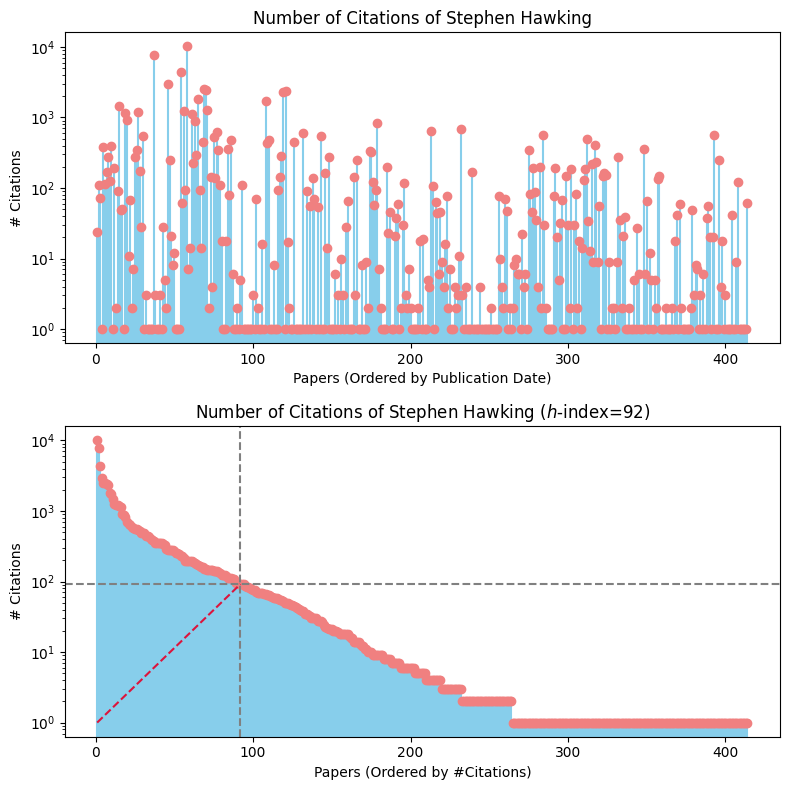

In [ ]:
# プロットの場所を用意する
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# グラフを作成します。logyを使うため、yをcitations+1にします。
# 上のグラフは発表日順に並べた論文の被引用数
plot_citations(axs[0], citations+1, logy="log",\
               xlabel='Papers (Ordered by Publication Date)',\
               title=f'Number of Citations of {name}')
# 下のグラフは被引用数順に並べた論文の被引用数
plot_citations(axs[1], citations_sorted+1, logy="log", h_index=h_index,\
               xlabel='Papers (Ordered by #Citations)', \
               title=f'Number of Citations of {name} ($h$-index={h_index})')
plt.tight_layout()
plt.show()

## 2. h-index指標の長期的予測性能

- (Row 1) キャリアの5年目の論文指標を利用し、10年目の総被引用数を予測するときには、sqrt(cited_first_5yrs)とh_index_first_5yrs（最初の5年の被引用数の平方根と第5年のh-index）は最も有用な指標である。
- (Row 2) さらに、キャリアの5年目の論文指標を利用し、5年目以降発表した論文の総被引用数を予測するときには、h_index_first_5yrsは最もいい予測指標である。

- X 
    * 'h_index_first_5yrs': h_index in the 5th years of the career.
    * 'cited_first_5yrs': cited_by_count in the first 5 years of the career.
    * 'works_first_5yrs': works_count in the first 5 years of the career.
    * 'cited_per_work_first_5yrs': cited_first_5yrs / works_first_5yrs.

- Y:
    * 'cited_first_10yrs': cited_by_count in the first 10 years of the career.
    * 'cited_6to10yrs': cited_by_count of papers published after the time of prediction.

/Users/ti/Library/Python/3.9/lib/python/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


Number of valid data for plotting: 18


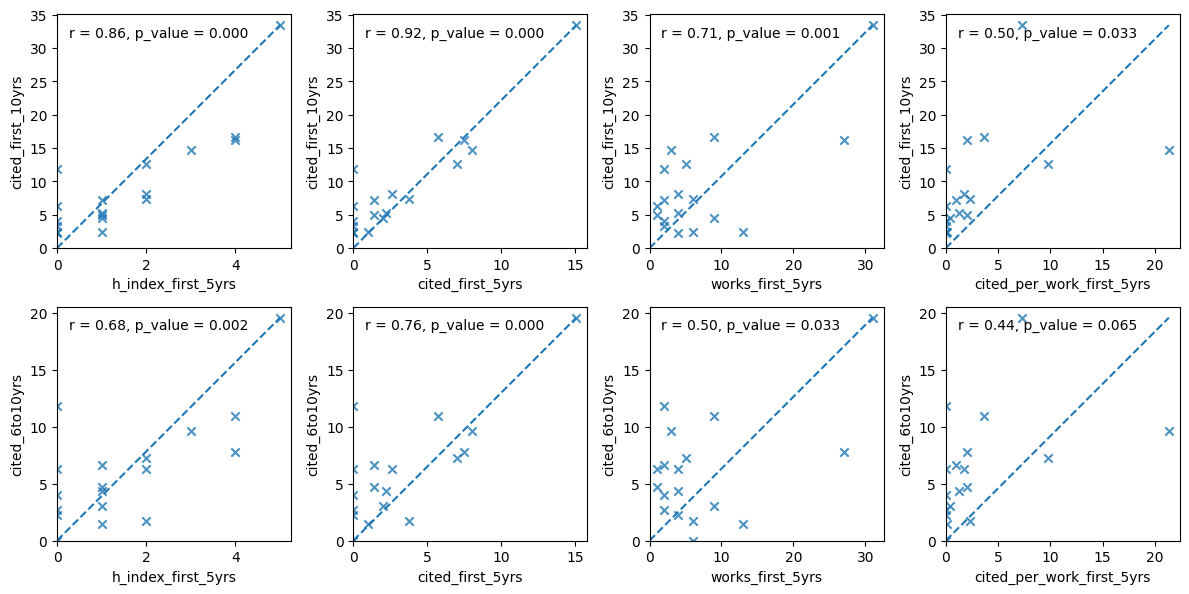

In [24]:
from scipy.stats import pearsonr

authors_valid = pd.read_pickle("./supplementary/authors_valid.pickle")

XX = authors_valid[['h_index_first_5yrs','cited_first_5yrs', 'works_first_5yrs', 'cited_per_work_first_5yrs']].copy()
YY = authors_valid[['cited_first_10yrs', 'cited_6to10yrs']].copy()
XX[['cited_first_5yrs']] = np.sqrt(XX[['cited_first_5yrs']])
YY = YY.apply(np.sqrt).dropna()
XX = XX[XX.index.isin(YY.index)]

print(f'Number of valid data for plotting: {len(YY)}')

# Plot scattered graphs for all combinations of XX and YY
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i, x_col in enumerate(XX.columns):
    for j, y_col in enumerate(YY.columns):
        ax = axs[j, i]
        ax.scatter(XX[x_col], YY[y_col], marker='x', alpha=0.8)
        ax.plot([0,max(XX[x_col])],[0,max(YY[y_col])], '--')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

        # Compute correlation coefficient (r)
        r, p_value = pearsonr(XX[x_col], YY[y_col])
        ax.text(0.05, 0.95, f'r = {r:.2f}, p_value = {p_value:.3f}', transform=ax.transAxes, ha='left', va='top')

plt.tight_layout()
plt.show()

# 探索

## 3．重回帰分析によるh-index予測

2016年時点のデータに基づいて2024年のh-indexを予測します。
(若手研究者のみに絞るため、2016年のcareer_age<=7の研究者を選択します)
- X：
    - h_index_2016: 2016年時点のh-index
    - affiliation_h_index: institution.summary_stats.h_index
    - gender：男性、女性
    - race：USでの人種。白人、アフリカ系、アジア系、ヒスパニック系
- Y:
    - h_index: 'author.summary_stats.h_index'

In [25]:
# [from_year, to_year]の間に発表された論文が[from_year, to_year]の間に獲得した被引用数
def get_citations(works_json, from_year, to_year):
        n = 0
        citations = []
        for work in works_json:
            if (from_year <= work['publication_year'] <= to_year):
                n += 1
                cited_by_count_after = sum(entry['cited_by_count'] for entry in work['counts_by_year'] 
                              if entry['year'] > to_year)
                citations.append(work['cited_by_count'] - cited_by_count_after)
            else:
                continue
        return citations
        
def calculate_h_index(citations):
    if len(citations)==0:
        return 0
    else:
        citations = np.array(citations)
        citations[::-1].sort()
        array = np.arange(1,citations.size+1)
        h_index = np.max(np.minimum(citations, array))
        return h_index

### 学習データの準備

#### Get data samples

APIを利用しデータを獲得するには時間がかかるため、30人の小規模サンプルでデータ処理のプロセスを示します。その後、事前に処理されたデータを読み込んで分析を行います。

In [26]:
# './supplementary/first_publication.pickle'から研究歴で若手の著者をサンプリングします
career_age_df=pd.read_pickle('./supplementary/first_publication.pickle') # 全部で10,000人分のcareer ageのデータが入っています。
career_age_df=career_age_df[(career_age_df['year']>=2016-7)&(career_age_df['year']<=2016-3)]\
    .reset_index(drop=True)\
    .sample(50)
    
print(f'Number of sampled authors: {career_age_df.shape[0]}')

Number of sampled authors: 50


In [27]:
# Get authors info by pyalex
authors_json = []
for id in tqdm.tqdm(career_age_df["id"]):
    authors_json.append(Authors()[id])
authors_df = pd.DataFrame(authors_json)

100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


In [28]:
# Get h_index
authors_df['h_index'] = authors_df['summary_stats'].apply(lambda x:x['h_index'])

# Clean up authors_df
authors_df = authors_df[['id','display_name','affiliations','counts_by_year','works_count','cited_by_count','h_index']]
# affiliation_h_indexが獲得できないデータを排除するため、affiliationsがあるデータを選択します。
authors_df = authors_df[authors_df['affiliations'].apply(len)>0]

# Get career_age
authors_df = pd.merge(authors_df, career_age_df, on='id', how='inner')
authors_df['career_age']=authors_df['year'].apply(lambda x:2016-x)

#### Get gender and ethnicity from the Namsor API.

Namsorでは、名前からジェンダー、人種・民族などを推測することができます。
https://namsor.app/ からログインしてAPI keyを取得しましょう。

In [32]:
import requests
import json

# API callを設定します。
# 推定したい名前をリストにして、APIの入力とします。
name_list=[]
for index, entry in authors_df.iterrows():
    name_list.append({"name": entry['display_name']})
payload = {"personalNames": name_list}

headers = {
    "X-API-KEY": "YOUR_API_KEY", # 取得したAPI_keyをこちらに入れてください。 
    "Accept": "application/json",
    "Content-Type": "application/json"
}

In [45]:
# Get gender and race data from 'display_name' by Namsor API
gender_url = "https://v2.namsor.com/NamSorAPIv2/api2/json/genderFullBatch"
gender_response = requests.request("POST", gender_url, json=payload, headers=headers)

race_url = "https://v2.namsor.com/NamSorAPIv2/api2/json/usRaceEthnicityFullBatch"
race_response = requests.request("POST", race_url, json=payload, headers=headers)

gender_response

# <Response [200]>と表示されれば正常にデータが取れています。
# Response [403]などはエラーです。403が表示される場合は、namsorから届いたメールのverification（認証）が取れていないか、
# すでに申請できる回数(5000回/月)を超えてしまったなど、うまくAPI keyが機能していない可能性が高いです。

<Response [200]>

In [34]:
# Get name-gender dictionary from response
gender_json=json.loads(gender_response.text)
personal_names = gender_json['personalNames']
gender_dict = {}
for entry in personal_names:
    name = entry['name']
    gender = str(entry['likelyGender'])
    gender_dict[name] = gender

# Show first 10 rows in gender_dict
pprint({k: gender_dict[k] for k in list(gender_dict)[:10]})

{'A. Forouzandeh': 'female',
 'A. Nguyen': 'male',
 'Ahmed Eltom': 'male',
 'Anton Linnet': 'male',
 'Armin Segref': 'male',
 'Atanu Kumar Behera': 'male',
 'Brittany L Loriquet': 'female',
 'Jaqueline Martins': 'female',
 'Jennifer Girard': 'female',
 'Montserrat Montaño-Fidalgo': 'female'}


In [35]:
# Get name-race dictionary from response
race_json=json.loads(race_response.text)
personal_names = race_json['personalNames']
race_dict = {}
for entry in personal_names:
    name = entry['name']
    race = str(entry['raceEthnicity'])
    race_dict[name] = race

# Show first 10 rows in race_dict
pprint({k: race_dict[k] for k in list(race_dict)[:10]})

# Race ethnicities, based on the US Census Taxonomy:
# W_NL: white, non latino ;
# HL: hispano latino ;
# A: asian, non latino ;
# B_NL: black, non latino .

{'A. Forouzandeh': 'A',
 'A. Nguyen': 'A',
 'Ahmed Eltom': 'W_NL',
 'Anton Linnet': 'W_NL',
 'Armin Segref': 'W_NL',
 'Atanu Kumar Behera': 'A',
 'Brittany L Loriquet': 'W_NL',
 'Jaqueline Martins': 'B_NL',
 'Jennifer Girard': 'W_NL',
 'Montserrat Montaño-Fidalgo': 'HL'}


In [36]:
# Assign gender and ethnicity to authors
authors_df['gender'] = authors_df['display_name'].apply(lambda x: gender_dict[x])
authors_df['race'] = authors_df['display_name'].apply(lambda x: race_dict[x])

#### Get other variables

In [ ]:
len(authors_df)

13

In [37]:
authors_df[['h_index_2016','affiliation_h_index']] = -1
authors_df['cited_per_work_first_5yrs'] = -1.0
predictor_year = 2016

for i, author in authors_df.iterrows():
    print("\r", f"{i+1} / {len(authors_df)} ({round(i / len(authors_df)*100,2)} %)" , end="")

    pyalexObj = Works().filter(author={"id":author["id"]},is_paratext=False, publication_year=f"<{predictor_year+1}")\
                       .select(['cited_by_count','counts_by_year','publication_year'])\
                       .sort(publication_year="asc")
    works_json = util.getAll(pyalexObj, verbous=False)
    if works_json==[]:
        continue

    # Calculate h_index_2016
    citations = get_citations(works_json, author['year'], predictor_year)
    authors_df.loc[i,'h_index_2016']=calculate_h_index(citations)
    
    # Calculate affiliation_h_index
    affiliations = author["affiliations"]
    year = predictor_year
    found = False
    authors_df.loc[i,'affiliation_h_index'] = -1
    while (not found) and (year >= predictor_year-7):
        for af in affiliations:
            if year in af['years']:
                affiliation_h_index = Institutions()[af['institution']['id']]['summary_stats']['h_index']
                if authors_df.loc[i,'affiliation_h_index'] < affiliation_h_index:
                    authors_df.loc[i,'affiliation_h_index'] = affiliation_h_index
                found = True
        year -= 1

 16 / 16 (93.75 %)

In [38]:
authors_df

,id,display_name,affiliations,counts_by_year,works_count,cited_by_count,h_index,year,career_age,gender,race,h_index_2016,affiliation_h_index,cited_per_work_first_5yrs
0,https://openalex.org/A5044418058,Ahmed Eltom,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",2,52,2,2013,3,male,W_NL,1,456,-1.0
1,https://openalex.org/A5036684758,A. Nguyen,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 1, 'cited_by_co...",2,0,0,2009,7,male,A,0,136,-1.0
2,https://openalex.org/A5022289517,A. Forouzandeh,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2021, 'works_count': 1, 'cited_by_co...",3,1,1,2009,7,female,A,0,-1,-1.0
3,https://openalex.org/A5077534108,Atanu Kumar Behera,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 1, 'cited_by_co...",5,15,2,2012,4,male,A,2,109,-1.0
4,https://openalex.org/A5083510931,Montserrat Montaño-Fidalgo,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",7,64,4,2009,7,female,HL,3,408,-1.0
5,https://openalex.org/A5057997712,Brittany L Loriquet,[{'institution': {'id': 'https://openalex.org/...,[],1,0,0,2011,5,female,W_NL,0,300,-1.0
6,https://openalex.org/A5010133499,Armin Segref,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 1, 'cited_by_co...",11,52,4,2011,5,male,W_NL,4,13,-1.0
7,https://openalex.org/A5050535709,Anton Linnet,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",2,27,2,2013,3,male,W_NL,1,33,-1.0
8,https://openalex.org/A5068258885,Jennifer Girard,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 1, 'cited_by_co...",17,192,6,2013,3,female,W_NL,2,549,-1.0
9,https://openalex.org/A5051902070,Jaqueline Martins,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2017, 'works_count': 1, 'cited_by_co...",2,0,0,2013,3,female,B_NL,0,-1,-1.0


### 学習と予測

In [39]:
# 同様にしてより多数の著者について取得したものを以下に挙げておきます。
# authors_df=pd.read_pickle('./supplementary/authors_h_index.pickle')

In [40]:
authors_valid=authors_df[authors_df['affiliation_h_index']>=0].reset_index(drop=True)
print(f'Number of valid data for regression: {authors_valid.shape[0]}')

Number of valid data for regression: 13


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Define X and y of multiple regression analysis
X = authors_valid[['h_index_2016','affiliation_h_index','race','gender','works_count']].copy()
y = authors_valid['h_index'].copy()

# Convert race and gender to one hot vectors
column_trans = ColumnTransformer(
    [('race_category',OneHotEncoder(),['race']),
     ('gender_category',OneHotEncoder(),['gender'])],
    remainder='passthrough'
)
X = pd.get_dummies(X, columns=['gender','race'])#, drop_first=True)
X = X.apply(lambda x: x.map({True: 1, False: 0}) if x.dtype == bool else x)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Set up model
model = LinearRegression()

# Fitting
model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = model.predict(X_train)

# Predictions on the test set
y_test_pred = model.predict(X_test)

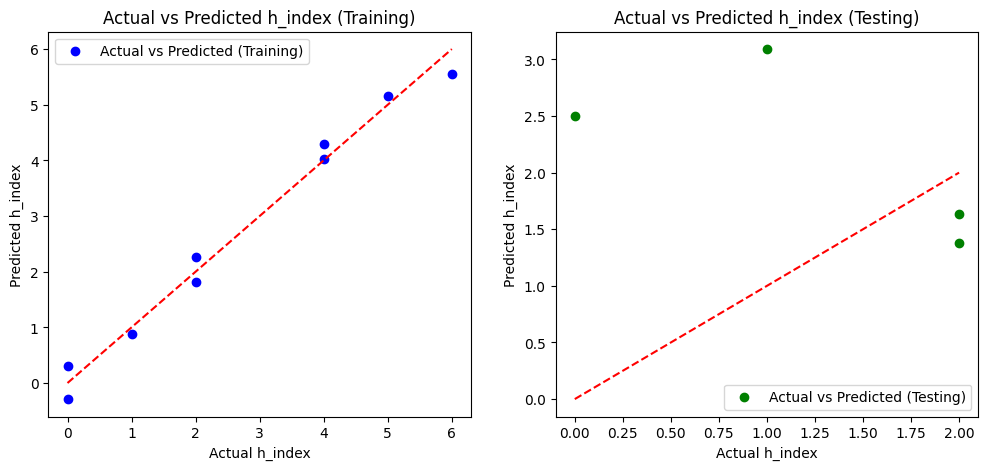

In [42]:
def plot_evaluation(ax, y, y_pred, *, type='', color='blue'):
    ax.scatter(y, y_pred, color=color, label=f'Actual vs Predicted ({type})')
    ax.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
    ax.set_xlabel('Actual h_index')
    ax.set_ylabel('Predicted h_index')
    ax.set_title(f'Actual vs Predicted h_index ({type})')
    ax.legend()
    
# 実測値と予測値の比較のグラフを作成する
fig, axs = plt.subplots(1,2,figsize=(12,5))
plot_evaluation(axs[0], y_train, y_train_pred, type='Training',color='blue')
plot_evaluation(axs[1], y_test, y_test_pred, type='Testing',color='green')
plt.show()

# データ点が不足しているのでほとんど精度が出ません。

In [43]:
# Evaluate the model using R^2 score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training set R^2 score:", train_r2)
print("Testing set R^2 score:", test_r2)

Training set R^2 score: 0.9842092405239526
Testing set R^2 score: -3.0575901581574136


{'affiliation_h_index': '0.002',
 'gender_female': '0.656',
 'gender_male': '-0.656',
 'h_index_2016': '0.675',
 'race_A': '-0.112',
 'race_HL': '-0.397',
 'race_W_NL': '0.509',
 'works_count': '0.074'}


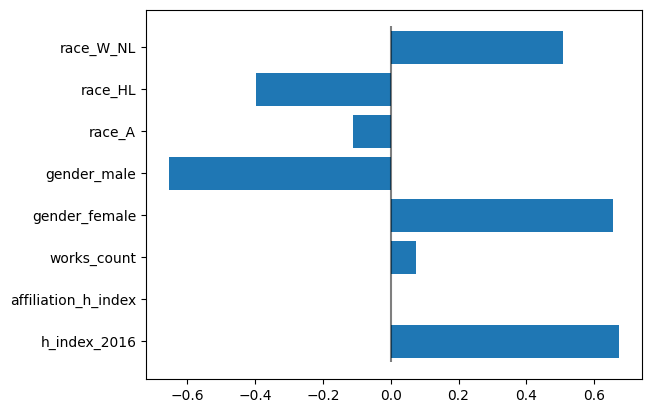

In [44]:
np.set_printoptions(suppress=True)
coefficients = {col: f'{coef:.3f}' for col, coef in zip(X.columns, model.coef_)}
pprint(coefficients)
plt.barh(np.arange(0,len(coefficients)),[float(v) for v in coefficients.values()],tick_label=list(coefficients.keys()))
plt.vlines(0,ymin=-0.5,ymax=len(coefficients)-0.5, colors='black', alpha=0.5)

# チュートリアルにて紹介した時と比べてデータ点が少ないのでかなり不安定な結果が出ます（リサンプリングすると結果が大きく変わります）。

W_NL: white, non latino ;
HL: hispano latino ;
A: asian, non latino ;
B_NL: black, non latino .

In [86]:
# len(X), len(X[X['race_W_NL']==1])

(84, 27)

# Playground

##  大学別h-index高い順に並べる

In [32]:
# 世界中の大学のh-indexランキング
ins_json = Institutions().select(['display_name','country_code','works_count','cited_by_count','summary_stats'])\
                         .sort(summary_stats={'h_index':'desc'}).get(per_page=10)
ins_df = pd.DataFrame(ins_json)

# Get h-index
ins_df['h_index'] = ins_df['summary_stats'].apply(lambda x:x['h_index'])
ins_df = ins_df.drop(columns=['summary_stats'])

display(ins_df)

,display_name,country_code,works_count,cited_by_count,h_index
0,Harvard University,US,587541,34233000,1533
1,Stanford University,US,404814,20539231,1299
2,Massachusetts Institute of Technology,US,270986,15461728,1198
3,Howard Hughes Medical Institute,US,82758,11935082,1180
4,"University of California, Berkeley",US,337646,16283225,1123
5,University of Washington,US,408778,16333769,1075
6,National Institutes of Health,US,235874,14733841,1066
7,Johns Hopkins University,US,374819,16328388,1061
8,University of Michigan–Ann Arbor,US,861048,16487312,1035
9,French National Centre for Scientific Research,FR,1038113,29837510,1032


In [33]:
# 日本の大学のh-indexランキング
ins_json = Institutions().select(['display_name','international','works_count','cited_by_count','summary_stats'])\
                         .filter(country_code='JP')\
                         .sort(summary_stats={'h_index':'desc'}).get(per_page=10)
ins_df = pd.DataFrame(ins_json)

# Get h-index
ins_df['h_index'] = ins_df['summary_stats'].apply(lambda x:x['h_index'])
ins_df = ins_df.drop(columns=['summary_stats'])

# Get Japanese name
jp_name = [entry['international']['display_name'].get('ja','-') for entry in ins_json]
ins_df['Japanese_name'] = jp_name
ins_df = ins_df.drop(columns=['international'])
ins_df.insert(ins_df.columns.get_loc('display_name') + 1, 'Japanese_name', ins_df.pop('Japanese_name'))

display(ins_df)

,display_name,Japanese_name,works_count,cited_by_count,h_index
0,The University of Tokyo,東京大学,402483,9996029,727
1,Kyoto University,京都大学,288894,7182048,646
2,Osaka University,大阪大学,246620,5589600,598
3,Japan Science and Technology Agency,-,52289,2651415,544
4,Tohoku University,東北大学,229793,4516434,493
5,Nagoya University,名古屋大学,170585,3378102,436
6,Kyushu University,九州大学,190124,3217406,420
7,National Institute of Advanced Industrial Scie...,産業技術総合研究所,80003,1890066,392
8,Tokyo Institute of Technology,東京工業大学,140341,2549463,391
9,Tokyo University of Science,東京理科大学,76864,1794774,389


## 個人のh-indexを時系列でプロット

Section2と似ているようなプロセスで、ある研究者のh-indexを時系列でプロットします。  
OpenAlexのデータの制限により、時系列は2011年から2024までだけができます。

In [34]:
# 著者を検索します
name = "J. E. Hirsch"

auth_json = Authors().search_filter(display_name=name)\
            .select(["id","display_name","relevance_score","works_count","cited_by_count","summary_stats"]).get()
auth_df = pd.DataFrame(auth_json)
auth_df = auth_df.join(pd.DataFrame(auth_df['summary_stats'].tolist()))
auth_df = auth_df.drop(columns=['summary_stats'])

display(auth_df.head())

,id,display_name,relevance_score,works_count,cited_by_count,2yr_mean_citedness,h_index,i10_index
0,https://openalex.org/A5036688434,J. E. Hirsch,11917.848000,466,31822,1.875,69,249
1,https://openalex.org/A5072780714,J. E. Hirsch,655.623660,4,79,0.000,3,2
2,https://openalex.org/A5005488196,J. E. Hirsch,33.365334,1,0,0.000,0,0
3,https://openalex.org/A5031101292,J. E. Hirsch,33.351562,1,0,0.000,0,0
4,https://openalex.org/A5039441333,J. E. Hirsch,33.351562,1,0,0.000,0,0


In [35]:
# 検索結果から著者を指定します
i = 0
auth_id = auth_df.loc[i,"id"]
print(auth_id)
auth_name = auth_df.loc[i,"display_name"]

# 著者データを確認します
data = Authors()[auth_id]
# 著者の最新の所属機関
institutions = [entry['display_name'] for entry in data['last_known_institutions']]
print('\nLast known institutions of the select author:')
pprint(institutions)
# 著者が発表した論文のテーマ
concepts = [entry['display_name'] for entry in data['x_concepts']]
print('\nConcepts of the select author:')
pprint(concepts)

https://openalex.org/A5036688434

Last known institutions of the select author:
['University of California, San Diego']

Concepts of the select author:
['Physics',
 'Quantum mechanics',
 'Condensed matter physics',
 'Superconductivity',
 'Mathematics',
 'Materials science',
 'Nuclear physics',
 'Chemistry',
 'Engineering',
 'Electron',
 'Thermodynamics',
 'Organic chemistry',
 'Computer science',
 'Medicine',
 'Biology',
 'Statistics']


Fetching 467 objects. it may takes 0.04 to 0.12 minutes


4it [00:04,  1.07s/it]


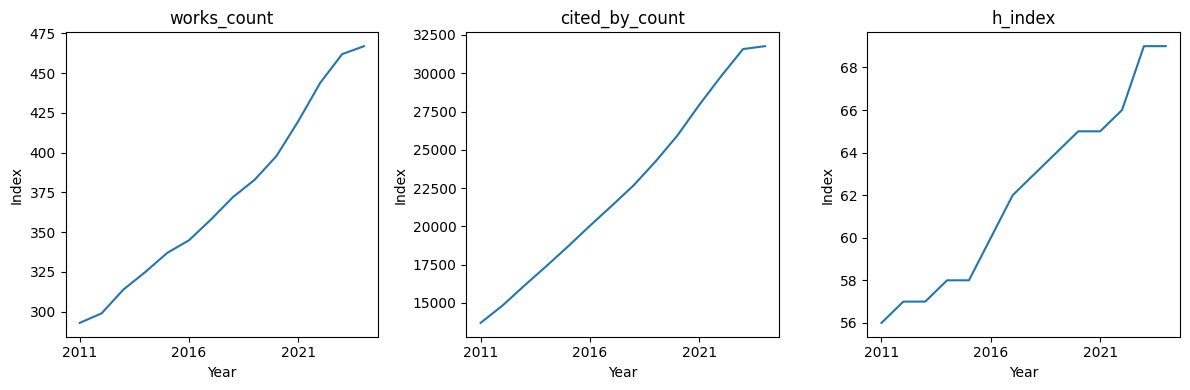

In [36]:
pyalexObj = Works().filter(author={"id":auth_id},is_paratext=False)\
                   .select(['cited_by_count','counts_by_year','publication_year'])\
                   .sort(publication_year="asc")
works_json = util.getAll(pyalexObj)

first_publication_year = works_json[0]["publication_year"] 
indices = pd.DataFrame(index=range(max(first_publication_year, 2011), 2025),
                         columns = ['works_count','cited_by_count','h_index'])

# Calculate h-index for each year
for year in range(max(first_publication_year, 2011), 2025):
    citations = get_citations(works_json, first_publication_year, year)
    indices.loc[year,'works_count']=len(citations)
    indices.loc[year,'cited_by_count']=sum(citations)
    indices.loc[year,'h_index']=calculate_h_index(citations)

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(indices.columns):
        ax = axs[i]
        ax.plot(indices.index, indices[col])
        ax.set_xlabel('Year')
        ax.set_ylabel('Index')
        ax.set_title(col)
        ax.set_xticks(indices.index[::5])

plt.tight_layout()
plt.show()